# Model selection throuh Optuna


In [ ]:
import numpy as np
import pandas as pd
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore")

# importlib.reload(data_clean_script)     # reload

In [ ]:
# !pip install optuna
# !pip install xgboost
# !pip install lightgbm
# !pip install mlflow
# !pip install dagshub

import mlflow
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 6.6 MB/s eta 0:00:00


In [ ]:
import dagshub

dagshub.init(repo_owner="rabin20-04", repo_name="delivery_time_prediction", mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=d28c5483-9878-4af8-b63f-e79992c3e408&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=157b9adc739b9d20021131529be539765948624661976d55b460a52bb144d77e




Accessing as rabin20-04

Initialized MLflow to track repo "rabin20-04/delivery_time_prediction"

Repository rabin20-04/delivery_time_prediction initialized!

In [7]:
from sklearn import set_config

set_config(transform_output="pandas")

#### Data


In [11]:
original_df = pd.read_csv("../data/raw/train.csv")

import sys
import importlib

sys.path.append("../data/files_/")
import data_clean_script

# importlib.reload(data_clean_script)

In [13]:
df = data_clean_script.perform_data_cleaning(original_df)

In [ ]:
df.sample(6)

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
21249,20.0,4.3,stormy,low,0,snack,motorcycle,1.0,no,metropolitian,20,1,15.0,morning,1.488329,short
21441,36.0,4.7,sandstorms,jam,1,buffet,motorcycle,1.0,no,urban,28,0,15.0,evening,13.970652,long
15461,27.0,4.9,stormy,low,2,buffet,scooter,1.0,no,metropolitian,16,0,10.0,night,10.866716,long
19674,31.0,4.8,cloudy,medium,1,buffet,motorcycle,1.0,no,urban,36,0,5.0,afternoon,10.565936,long
5239,29.0,4.8,fog,jam,1,meal,motorcycle,2.0,no,metropolitian,43,1,5.0,night,20.178299,very_long
38608,31.0,4.6,fog,medium,2,drinks,motorcycle,1.0,no,urban,19,1,10.0,afternoon,6.209976,medium


In [ ]:
df.columns.tolist()

['age',
 'ratings',
 'weather',
 'traffic',
 'vehicle_condition',
 'type_of_order',
 'type_of_vehicle',
 'multiple_deliveries',
 'festival',
 'city_type',
 'time_taken',
 'is_weekend',
 'pickup_time_minutes',
 'order_time_of_day',
 'distance',
 'distance_type']

In [ ]:
# df.drop(
#     columns={"city_name", "order_day_of_week", "order_month"}, axis=1, inplace=True
# )  # contains just two months data -- may lead to overfit

In [ ]:
df.shape

(45502, 16)

In [ ]:
df.isna().sum()

age                    1854
ratings                1908
weather                 525
traffic                 510
vehicle_condition         0
type_of_order             0
type_of_vehicle           0
multiple_deliveries     993
festival                228
city_type              1198
time_taken                0
is_weekend                0
pickup_time_minutes    1640
order_time_of_day      2070
distance               3630
distance_type          3630
dtype: int64

In [23]:
num_cols = ["age", "ratings", "pickup_time_minutes", "distance"]
# continuous | categorical | nominal

nominal_cat_cols = [
    "weather",
    "type_of_order",
    "type_of_vehicle",
    "festival",
    "city_type",
    "order_time_of_day",
    "is_weekend",
]
ordinal_cat_cols = ["traffic", "distance_type"]
traffic_order = ["low", "medium", "high", "jam"]
distance_order = ["short", "medium", "long", "very_long"]

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
mlflow.set_tracking_uri(
    "https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow"
)

In [ ]:
mlflow.set_experiment("EXP-4  Best Model selction - Optuna -colab ")

2025/06/30 13:49:27 INFO mlflow.tracking.fluent: Experiment with name 'EXP-4  Best Model selction - Optuna ' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/86c6ed12efbd42a98e3524eea46fe207', creation_time=1751270667734, experiment_id='2', last_update_time=1751270667734, lifecycle_stage='active', name='EXP-4  Best Model selction - Optuna ', tags={}>

# Drop missing


<Axes: >

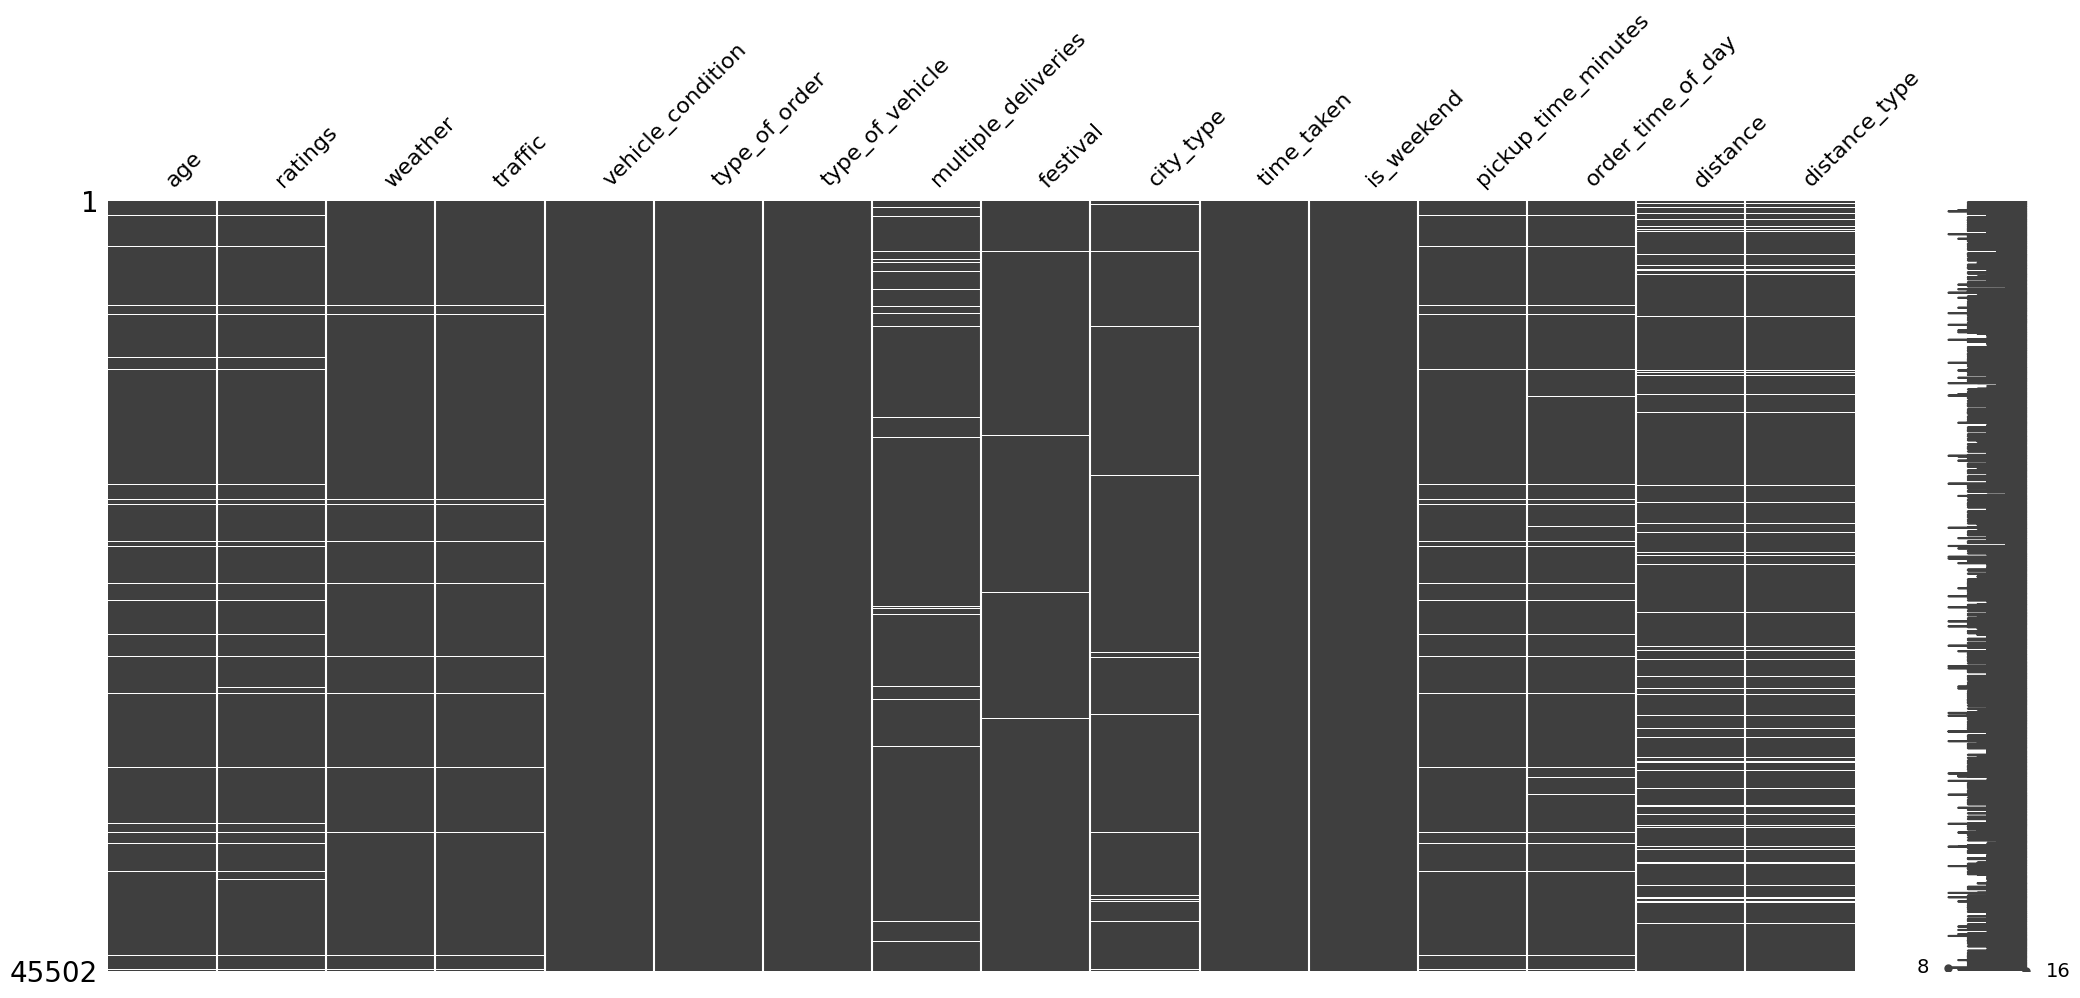

In [ ]:
msno.matrix(df)

In [ ]:
# Mnar

In [ ]:
import mlflow

In [ ]:
temp_df = df.copy().dropna()
# temp_df = pd.read_csv("/content/null_droped.csv")
temp_df.drop(columns="Unnamed: 0", axis=1, inplace=True)

temp_df.shape

(37695, 16)

In [49]:
X = temp_df.drop(columns="time_taken", axis=1)
y = temp_df["time_taken"]

In [50]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
xtrain.shape, xtest.shape, ytrain.shape, ytest.shape,

((30156, 15), (7539, 15), (30156,), (7539,))

In [52]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30156 entries, 7204 to 15795
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  30156 non-null  float64
 1   ratings              30156 non-null  float64
 2   weather              30156 non-null  object 
 3   traffic              30156 non-null  object 
 4   vehicle_condition    30156 non-null  int64  
 5   type_of_order        30156 non-null  object 
 6   type_of_vehicle      30156 non-null  object 
 7   multiple_deliveries  30156 non-null  float64
 8   festival             30156 non-null  object 
 9   city_type            30156 non-null  object 
 10  is_weekend           30156 non-null  int64  
 11  pickup_time_minutes  30156 non-null  float64
 12  order_time_of_day    30156 non-null  object 
 13  distance             30156 non-null  float64
 14  distance_type        30156 non-null  object 
dtypes: float64(5), int64(2), object(8)
mem

## Preprocessing


In [53]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", MinMaxScaler(), num_cols),
        (
            "nominal_encode",
            OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
            nominal_cat_cols,
        ),
        (
            "ordinal_encode",
            OrdinalEncoder(categories=[traffic_order, distance_order]),
            ordinal_cat_cols,
        ),
    ],
    remainder="passthrough",
    n_jobs=3,
    verbose_feature_names_out=False,
)
preprocessor.set_output(transform="pandas")

ColumnTransformer(n_jobs=3, remainder='passthrough',
                  transformers=[('scale', MinMaxScaler(),
                                 ['age', 'ratings', 'pickup_time_minutes',
                                  'distance']),
                                ('nominal_encode',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               sparse_output=False),
                                 ['weather', 'type_of_order', 'type_of_vehicle',
                                  'festival', 'city_type', 'order_time_of_day',
                                  'is_weekend']),
                                ('ordinal_encode',
                                 OrdinalEncoder(categories=[['low', 'medium',
                                                             'high', 'jam'],
                                                            ['short', 'medium',
                                                             'long',
                                                             'very_long']]),
                                 ['traffic', 'distance_type'])],
                  verbose_feature_names_out=False)

In [54]:
temp_df

,age,ratings,weather,traffic,vehicle_condition,type_of_order,type_of_vehicle,multiple_deliveries,festival,city_type,time_taken,is_weekend,pickup_time_minutes,order_time_of_day,distance,distance_type
0,37.0,4.9,sunny,high,2,snack,motorcycle,0.0,no,urban,24,1,15.0,morning,3.025149,short
1,34.0,4.5,stormy,jam,2,snack,scooter,1.0,no,metropolitian,33,0,5.0,evening,20.183530,very_long
2,23.0,4.4,sandstorms,low,0,drinks,motorcycle,1.0,no,urban,26,1,15.0,morning,1.552758,short
3,38.0,4.7,sunny,medium,0,buffet,motorcycle,1.0,no,metropolitian,21,0,10.0,evening,7.790401,medium
4,32.0,4.6,cloudy,high,1,snack,scooter,1.0,no,metropolitian,30,1,15.0,afternoon,6.210138,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37690,35.0,4.2,windy,jam,2,drinks,motorcycle,1.0,no,metropolitian,33,0,10.0,night,16.600272,very_long
37691,30.0,4.8,windy,high,1,meal,motorcycle,0.0,no,metropolitian,32,0,10.0,morning,1.489846,short
37692,30.0,4.9,cloudy,low,1,drinks,scooter,0.0,no,metropolitian,16,0,15.0,night,4.657195,short
37693,20.0,4.7,cloudy,high,0,snack,motorcycle,1.0,no,metropolitian,26,0,5.0,afternoon,6.232393,medium


In [55]:
temp_df.columns

Index(['age', 'ratings', 'weather', 'traffic', 'vehicle_condition',
       'type_of_order', 'type_of_vehicle', 'multiple_deliveries', 'festival',
       'city_type', 'time_taken', 'is_weekend', 'pickup_time_minutes',
       'order_time_of_day', 'distance', 'distance_type'],
      dtype='object')

In [56]:
temp_df.shape

(37695, 16)

In [57]:
X_train_trans = preprocessor.fit_transform(xtrain)
X_test_trans = preprocessor.transform(xtest)
pt = PowerTransformer()
y_train_pt = pt.fit_transform(ytrain.values.reshape(-1, 1))
y_test_pt = pt.transform(ytest.values.reshape(-1, 1))

In [58]:
X_test_trans.head()

,age,ratings,pickup_time_minutes,distance,weather_fog,weather_sandstorms,weather_stormy,weather_sunny,weather_windy,type_of_order_drinks,...,city_type_semi-urban,city_type_urban,order_time_of_day_evening,order_time_of_day_morning,order_time_of_day_night,is_weekend_1,traffic,distance_type,vehicle_condition,multiple_deliveries
37469,0.157895,0.84,1.0,0.239096,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0,0.0
33249,0.526316,0.80,0.5,0.476360,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,2.0,2,1.0
19970,0.368421,0.68,0.5,0.545261,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,2.0,0,1.0
4405,0.789474,0.96,0.5,0.484974,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0,1.0
24929,0.157895,0.96,0.5,0.623770,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,0,1.0


In [59]:
X_train_trans.shape

(30156, 25)

<Axes: >

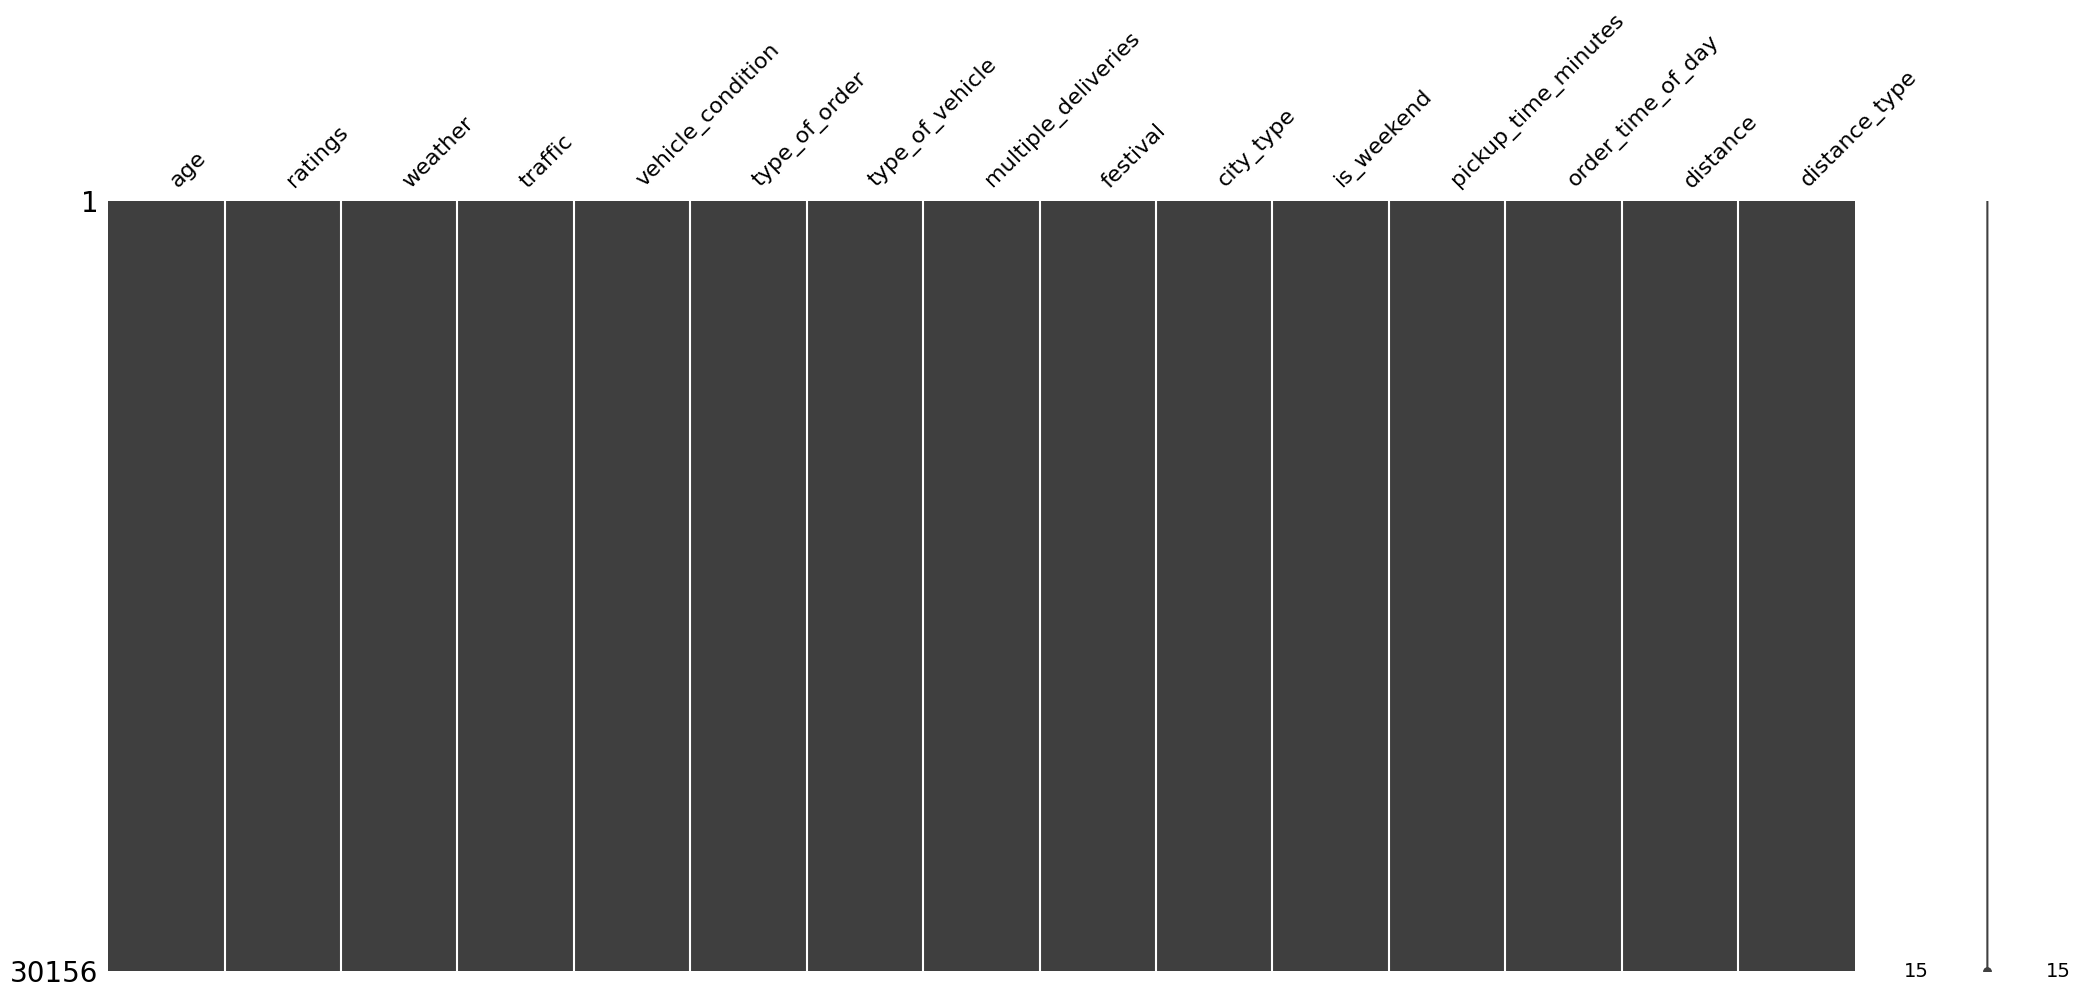

In [60]:
msno.matrix(xtrain)

## Optuna


In [61]:
def objective(trial):
    with mlflow.start_run(nested=True):
        model_name = trial.suggest_categorical(
            "model", ["SVM", "RF", "KNN", "GB", "XGB", "LGBM"]
        )

        if model_name == "SVM":
            kernel_svm = trial.suggest_categorical(
                "kernel_svm", ["linear", "poly", "rbf"]
            )
            if kernel_svm == "linear":
                c_linear = trial.suggest_float("c_linear", 0, 10)
                model = SVR(C=c_linear, kernel="linear")

            elif kernel_svm == "poly":
                c_poly = trial.suggest_float("c_poly", 0, 10)
                degree_poly = trial.suggest_int("degree_poly", 1, 5)
                model = SVR(C=c_poly, degree=degree_poly, kernel="poly")

            else:
                c_rbf = trial.suggest_float("c_rbf", 0, 100)
                gamma_rbf = trial.suggest_float("gamma_rbf", 0, 10)
                model = SVR(C=c_rbf, gamma=gamma_rbf, kernel="rbf")

        elif model_name == "RF":
            n_estimators_rf = trial.suggest_int("n_estimators_rf", 10, 200)
            max_depth_rf = trial.suggest_int("max_depth_rf", 2, 20)
            model = RandomForestRegressor(
                n_estimators=n_estimators_rf,
                max_depth=max_depth_rf,
                random_state=42,
                n_jobs=-1,
            )

        elif model_name == "GB":
            n_estimators_gb = trial.suggest_int("n_estimators_gb", 10, 200)
            learning_rate_gb = trial.suggest_float("learning_rate_gb", 0, 1)
            max_depth_gb = trial.suggest_int("max_depth_gb", 2, 20)
            model = GradientBoostingRegressor(
                n_estimators=n_estimators_gb,
                learning_rate=learning_rate_gb,
                max_depth=max_depth_gb,
                random_state=42,
            )

        elif model_name == "KNN":
            n_neighbors_knn = trial.suggest_int("n_neighbors_knn", 1, 25)
            weights_knn = trial.suggest_categorical(
                "weights_knn", ["uniform", "distance"]
            )
            model = KNeighborsRegressor(
                n_neighbors=n_neighbors_knn, weights=weights_knn, n_jobs=-1
            )

        elif model_name == "XGB":
            n_estimators_xgb = trial.suggest_int("n_estimators_xgb", 10, 200)
            learning_rate_xgb = trial.suggest_float("learning_rate_xgb", 0.1, 0.5)
            max_depth_xgb = trial.suggest_int("max_depth_xgb", 2, 20)
            model = XGBRegressor(
                n_estimators=n_estimators_xgb,
                learning_rate=learning_rate_xgb,
                max_depth=max_depth_xgb,
                random_state=42,
                n_jobs=-1,
            )

        elif model_name == "LGBM":
            n_estimators_lgbm = trial.suggest_int("n_estimators_lgbm", 10, 200)
            learning_rate_lgbm = trial.suggest_float("learning_rate_lgbm", 0.1, 0.5)
            max_depth_lgbm = trial.suggest_int("max_depth_lgbm", 2, 20)
            model = LGBMRegressor(
                n_estimators=n_estimators_lgbm,
                learning_rate=learning_rate_lgbm,
                max_depth=max_depth_lgbm,
                random_state=42,
            )

        model.fit(X_train_trans, y_train_pt.values.ravel())

        mlflow.log_params(model.get_params())

        y_pred_train = model.predict(X_train_trans)
        y_pred_test = model.predict(X_test_trans)

        y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
        y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

        error = mean_absolute_error(ytest, y_pred_test_org)

        mlflow.log_param("model", model_name)

        mlflow.log_metric("MAE", error)

        return error

In [62]:
study = optuna.create_study(direction="minimize", study_name="model_selection")

with mlflow.start_run(run_name="Best Model") as parent:

    study.optimize(objective, n_trials=30, n_jobs=-1, show_progress_bar=True)

    mlflow.log_params(study.best_params)

    mlflow.log_metric("best_score", study.best_value)

[I 2025-06-30 08:58:34,180] A new study created in memory with name: model_selection


  0%|          | 0/30 [00:00<?, ?it/s]

🏃 View run bedecked-perch-118 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0/runs/5782104eecf64843a65469f804a1c619
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0
[I 2025-06-30 08:58:38,654] Trial 1 finished with value: 3.065381647375074 and parameters: {'model': 'LGBM', 'n_estimators_lgbm': 80, 'learning_rate_lgbm': 0.21662030547075034, 'max_depth_lgbm': 16}. Best is trial 1 with value: 3.065381647375074.
🏃 View run skillful-sponge-311 at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0/runs/a6953caec68b4459ac874d5f08c35b11
🧪 View experiment at: https://dagshub.com/rabin20-04/delivery_time_prediction.mlflow/#/experiments/0
[I 2025-06-30 08:58:43,985] Trial 0 finished with value: 4.662582357013858 and parameters: {'model': 'RF', 'n_estimators_rf': 155, 'max_depth_rf': 4}. Best is trial 1 with value: 3.065381647375074.
🏃 View run ambitious-loon-743 at: https://dagshub.

In [ ]:
study.best_params


# {'model': 'LGBM',
#  'n_estimators_lgbm': 146,
#  'learning_rate_lgbm': 0.11236909502880069,
#  'max_depth_lgbm': 10}
# {'model': 'GB',
#  'n_estimators_gb': 121,
#  'learning_rate_gb': 0.0510257391863774,
#  'max_depth_gb': 9}

{'model': 'LGBM',
 'n_estimators_lgbm': 114,
 'learning_rate_lgbm': 0.19232864336594527,
 'max_depth_lgbm': 9}

In [66]:
# train the model on best parameters

lgbm_params = study.best_params
lgbm = LGBMRegressor(**lgbm_params)

lgbm.fit(X_train_trans, y_train_pt.values.ravel())

[LightGBM] [Warning] Unknown parameter: n_estimators_lgbm
[LightGBM] [Warning] Unknown parameter: max_depth_lgbm
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: learning_rate_lgbm
[LightGBM] [Warning] Unknown parameter: n_estimators_lgbm
[LightGBM] [Warning] Unknown parameter: max_depth_lgbm
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: learning_rate_lgbm
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004469 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 352
[LightGBM] [Info] Number of data points in the train set: 30156, number of used features: 25
[LightGBM] [Info] Start training from score -0.000000


LGBMRegressor(learning_rate_lgbm=0.19232864336594527, max_depth_lgbm=9,
              model='LGBM', n_estimators_lgbm=114)

In [ ]:
y_pred_train = lgbm.predict(X_train_trans)
y_pred_test = lgbm.predict(X_test_trans)

[LightGBM] [Warning] Unknown parameter: n_estimators_lgbm
[LightGBM] [Warning] Unknown parameter: max_depth_lgbm
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: learning_rate_lgbm
[LightGBM] [Warning] Unknown parameter: n_estimators_lgbm
[LightGBM] [Warning] Unknown parameter: max_depth_lgbm
[LightGBM] [Warning] Unknown parameter: model
[LightGBM] [Warning] Unknown parameter: learning_rate_lgbm


In [ ]:
y_pred_train_org = pt.inverse_transform(y_pred_train.reshape(-1, 1))
y_pred_test_org = pt.inverse_transform(y_pred_test.reshape(-1, 1))

In [69]:
from sklearn.metrics import mean_absolute_error, r2_score

print(f"The train error is {mean_absolute_error(ytrain,y_pred_train_org):.2f} minutes")
print(f"The test error is {mean_absolute_error(ytest,y_pred_test_org):.2f} minutes")

The train error is 2.97 minutes
The test error is 3.05 minutes


In [70]:
print(f"The train r2 score is {r2_score(ytrain,y_pred_train_org):.2f}")
print(f"The test r2 score is {r2_score(ytest,y_pred_test_org):.2f}")

The train r2 score is 0.85
The test r2 score is 0.83


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_c_linear,params_c_poly,params_c_rbf,params_degree_poly,params_gamma_rbf,...,params_max_depth_rf,params_max_depth_xgb,params_model,params_n_estimators_gb,params_n_estimators_lgbm,params_n_estimators_rf,params_n_estimators_xgb,params_n_neighbors_knn,params_weights_knn,state
0,0,4.662582,2025-06-30 08:58:34.486320,2025-06-30 08:58:43.985459,0 days 00:00:09.499139,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,RF,NaN,NaN,155.0,NaN,NaN,NaN,COMPLETE
1,1,3.065382,2025-06-30 08:58:34.497364,2025-06-30 08:58:38.654524,0 days 00:00:04.157160,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,LGBM,NaN,80.0,NaN,NaN,NaN,NaN,COMPLETE
2,2,3.738238,2025-06-30 08:58:38.662512,2025-06-30 09:09:29.633534,0 days 00:10:50.971022,NaN,5.092404,NaN,3.0,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,4.157666,2025-06-30 08:58:44.003751,2025-06-30 08:59:05.854320,0 days 00:00:21.850569,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,GB,51.0,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,3.381438,2025-06-30 08:59:05.867256,2025-06-30 08:59:45.848821,0 days 00:00:39.981565,NaN,NaN,NaN,NaN,NaN,...,NaN,16.0,XGB,NaN,NaN,NaN,113.0,NaN,NaN,COMPLETE
5,5,4.675475,2025-06-30 08:59:45.866099,2025-06-30 09:10:10.341367,0 days 00:10:24.475268,5.472316,NaN,NaN,NaN,NaN,...,NaN,NaN,SVM,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
6,6,4.663587,2025-06-30 09:09:29.647551,2025-06-30 09:09:40.280681,0 days 00:00:10.633130,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,RF,NaN,NaN,176.0,NaN,NaN,NaN,COMPLETE
7,7,3.072353,2025-06-30 09:09:40.291576,2025-06-30 09:10:07.542758,0 days 00:00:27.251182,NaN,NaN,NaN,NaN,NaN,...,17.0,NaN,RF,NaN,NaN,122.0,NaN,NaN,NaN,COMPLETE
8,8,4.220218,2025-06-30 09:10:07.554548,2025-06-30 09:10:20.492462,0 days 00:00:12.937914,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,23.0,distance,COMPLETE
9,9,4.248874,2025-06-30 09:10:10.358625,2025-06-30 09:10:36.169504,0 days 00:00:25.810879,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,KNN,NaN,NaN,NaN,NaN,11.0,uniform,COMPLETE


In [ ]:
# model frequency

study.trials_dataframe()["params_model"].value_counts()

,count
params_model,
LGBM,14
KNN,4
RF,3
SVM,3
GB,3
XGB,3


In [ ]:
# avg scores for all tested models

study.trials_dataframe().groupby("params_model")["value"].mean().sort_values()

,value
params_model,
LGBM,3.129447
XGB,3.978766
RF,4.132841
GB,4.236421
KNN,4.773859
SVM,4.850832


In [74]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(regressor=lgbm, transformer=pt)

In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(
    model, X_train_trans, ytrain, scoring="neg_mean_absolute_error", cv=5, n_jobs=-1
)

scores

array([-3.08875699, -3.07222064, -3.07556268, -3.09114835, -3.04729934])

In [ ]:
-scores.mean()

np.float64(3.0749976000159767)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=["model"])